### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 14 мая 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте.

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге.

Таргет - антиградиент по функции потерь по текущим предсказаниям модели:

1. для MSE: $- \frac{\partial L}{\partial a(x_i)} = 2 \cdot (y_i - a(x_i))$

2. для экспоненциональной функции потерь: $- \frac{\partial L}{\partial a(x_i)} = exp( -a(x_i) y_i) \cdot y_i$

3. для логистической функции потерь: $- \frac{\partial L}{\partial a(x_i)} = \frac{exp( -a(x_i) y_i) \cdot y_i}{1 + exp( -a(x_i) y_i)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn.


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [ ]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

from scipy.stats import mode

import pandas as pd

from tqdm import tqdm

In [52]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
class MyGradientBoostingClassifier:

    def __init__(self,
                 loss = 'mse',
                 learning_rate = 0.1,
                 n_estimators = 100,
                 colsample = 1.0,
                 subsample = 1.0,
                 *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.loss = loss

        if loss == 'mse':
            self.loss_func = self.mse_grad
        elif loss == 'exponential':
            self.loss_func = self.exp_grad
        elif loss == 'log_loss':
            self.loss_func = self.logloss_grad
        else:
            raise ValueError("Unsupported loss function. Choose 'mse', 'exponential', or 'log_loss'.")

    def mse_grad(self, y, pred):
        return 2 * (y - pred)

    def exp_grad(self, y, pred):
        return y * np.exp(-pred * y)

    def logloss_grad(self, y, pred):
        exp = np.exp(-pred * y)
        return y * exp / (1 + exp)

    def fit(self, X, y, base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.models = []

        if init_model is None:
            self.init_model  = lambda X: np.full(X.shape[0],  mode(y).mode, dtype=float)
            y_pred = self.init_model(X)
        else:
            self.init_model = init_model()
            self.init_model.fit(X, y)
            y_pred = self.init_model.predict(X).astype(float)

        for i in range(self.n_estimators):
            obj_sample_idx = np.random.choice(X.shape[0],
                                 int(X.shape[0] * self.subsample),
                                 replace=False)
            feature_sample = np.random.choice(X.shape[1],
                                 int(X.shape[1] * self.colsample),
                                 replace=False)
            sample_X, sample_y = X[obj_sample_idx], y[obj_sample_idx]

            grad = self.loss_func(y, y_pred)

            estimator = base_model(*self.args, **self.kwargs)
            estimator.fit(sample_X[:, feature_sample], grad[obj_sample_idx])

            y_pred += self.learning_rate * estimator.predict(X[:, feature_sample])

            self.models.append((estimator, feature_sample))

    def predict(self, X):
        if hasattr(self.init_model, 'predict'):
            y_pred = self.init_model.predict(X).astype(float)
        else:
            y_pred = self.init_model(X)

        for model, features in self.models:
            y_pred += self.learning_rate * model.predict(X[:, features])

        if self.loss == 'mse':
            return np.around(y_pred).astype(int)
        else:
            return np.where(y_pred >= 0, 1, -1)

    def get_params(self, deep=True):
        return {'loss': self.loss, 'n_estimators': self.n_estimators,
                'colsample': self.colsample, 'subsample': self.subsample,
                'learning_rate': self.learning_rate}

    def set_params(self, **params):
        valid_params = self.get_params(deep=True)
        for key, value in params.items():
            if key not in valid_params:
                raise ValueError("Invalid parameter %s for estimator %s. "
                                 "Check the list of available parameters "
                                 "with `estimator.get_params().keys()`." % (key, self.__class__.__name__))
            setattr(self, key, value)
        return self

In [ ]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [ ]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target, random_state=42)

In [ ]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации.


In [1]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [ ]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
loss_plt = {'mse': [], 'log_loss': [], 'exponential': []}

In [ ]:
for loss in tqdm(loss_plt.keys()):
    for n_estimators in tqdm(range(5, 100, 5), desc=loss, leave=False):
        my_clf = MyGradientBoostingClassifier(loss=loss, n_estimators=n_estimators, random_state=42)
        my_clf.fit(X_train, y_train if loss == 'mse' else 2 * y_train - 1)
        pred = my_clf.predict(X_test)
        loss_plt[loss].append(accuracy_score(y_pred=pred, y_true=y_test if loss == 'mse' else 2 * y_test - 1))

100%|██████████| 3/3 [09:42<00:00, 194.02s/it]


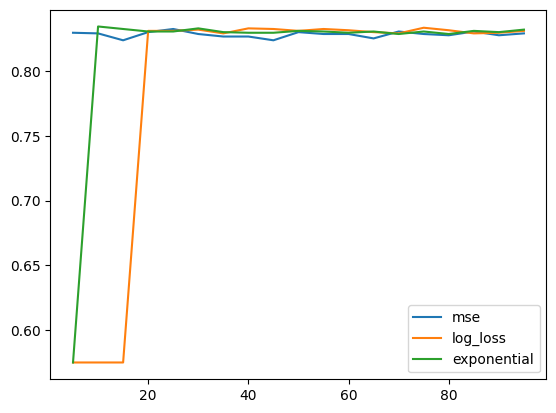

In [ ]:
for loss in loss_plt.keys():
    plt.plot(list(range(5, 100, 5)), loss_plt[loss], label=loss)

plt.legend()
plt.show()

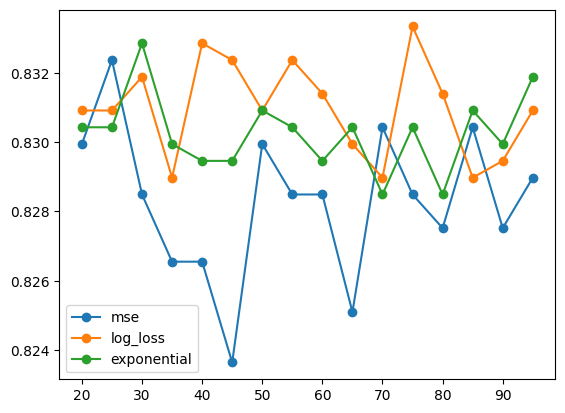

In [ ]:
for loss in loss_plt.keys():
    plt.plot(list(range(20, 100, 5)), loss_plt[loss][3:], label=loss, marker='o')

plt.legend()
plt.show()

При 20+ итерациях у всех моделей +- одинаковое качество. MSE дает сразу хороший результат, который потом ухудшается, а вот с логистической и экспоненциальной функциями потерь модель при увеличении итераций с 5 до 20 становится заметно лучше, потом колеблется между 0.83 и 0.832.

In [ ]:
from sklearn.model_selection import GridSearchCV

CV = GridSearchCV(estimator=MyGradientBoostingClassifier(n_estimators=20, random_state=42),
                  param_grid={'colsample': np.linspace(0.5, 1, 6),
                              'subsample': np.linspace(0.5, 1, 6),
                              'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]},
                  n_jobs=-1, return_train_score=True,
                  scoring='accuracy')

CV.fit(X_train, y_train)

GridSearchCV(estimator=<__main__.MyGradientBoostingClassifier object at 0x789da8e60f10>,
             n_jobs=-1,
             param_grid={'colsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0],
                         'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             return_train_score=True, scoring='accuracy')

In [ ]:
CV.best_params_

{'colsample': 0.8, 'learning_rate': 0.05, 'subsample': 0.9}

In [ ]:
CV.best_score_

0.8880808319340758

In [33]:
CV = GridSearchCV(estimator=MyGradientBoostingClassifier(n_estimators=20, random_state=42),
                  param_grid={'loss': ['exponential', 'log_loss'],
                              'colsample': np.linspace(0.5, 1, 6),
                              'subsample': np.linspace(0.5, 1, 6),
                              'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]},
                              n_jobs=-1, return_train_score=True,
                              scoring='accuracy')

CV.fit(X_train, 2 * y_train - 1)

CV.best_params_

{'colsample': 0.8, 'learning_rate': 0.05, 'loss': 'log_loss', 'subsample': 0.9}

In [34]:
CV.best_score_

0.8857124044001641

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
my_clf = MyGradientBoostingClassifier(n_estimators=20, loss='mse',
                                      colsample=0.8, learning_rate=0.05,
                                      subsample=0.9,
                                      random_state=42, n_jobs=-1)

my_clf.fit(X=X_train, y=y_train, base_model=RandomForestRegressor)
accuracy_score(y_true=y_test, y_pred=my_clf.predict(X_test))

0.877422480620155

In [49]:
predictions = []

for i in range(10):
    bootstrap_idx = np.random.choice(range(X_train.shape[0]), replace=True, size=X_train.shape[0])
    X_bootstrap, y_bootstrap = X_train[bootstrap_idx], y_train[bootstrap_idx]

    my_clf = MyGradientBoostingClassifier(n_estimators=20, loss='mse',
                                          colsample=0.8, learning_rate=0.05,
                                          subsample=0.9)

    my_clf.fit(X=X_bootstrap, y=y_bootstrap)
    predictions.append(my_clf.predict(X_test))

prediction = np.round(np.mean(predictions, axis=0))
accuracy_score(y_pred=prediction, y_true=y_test)

0.874031007751938

В обоих случаях стало немного хуже, в первом мы использовали случайный лес как базовую модель - случайный лес и так достаточно сильная модель, поэтому возможно такое, что на первый итерациях мы добились почти нулевого градиента и больше ничего не улучшали. Возможно, этого можно было избежать, если задать параметры для леса. Бэггинг наших классификаторов тоже не улучшил изначальный результат, возможно мы где-то слишком сильно подстроились под бутстрапированную выборку.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [51]:
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [55]:
for init_model in [SVR, LogisticRegression, LinearRegression, RandomForestRegressor]:
    my_clf = MyGradientBoostingClassifier(n_estimators=20, loss='mse',
                                          colsample=0.8, learning_rate=0.05,
                                          subsample=0.9, random_state=42)
    my_clf.fit(X_train, y_train, init_model=init_model)
    print(f"init model: {init_model.__name__}, accuracy_score: {accuracy_score(y_true=y_test, y_pred=my_clf.predict(X_test))}")

init model: SVR, accuracy_score: 0.8900193798449613
init model: LogisticRegression, accuracy_score: 0.8357558139534884
init model: LinearRegression, accuracy_score: 0.8846899224806202
init model: RandomForestRegressor, accuracy_score: 0.8842054263565892


Удалось перебить оригинальный результат только SVR, остальные модели показали качество примерно такое же или чуть хуже, чем у оригинально модели после гридсерча. Если зависимость таргета от данных не похожа на линейную, то это может быть слабым стартом, который не компенсируется даже последующими итерациями.